# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.RandomState(0)

In [39]:
region = [50e3, 150e3, 100e3, 250e3]
height = 1500
#coordinates = vd.scatter_points(region, size=1000, random_state=0, extra_coords=height)
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(20, 20), extra_coords=height)]
x, y, z = coordinates
center = [110e3, 200e3, -5e3]
mass = 200 * 4 / 3 * np.pi * np.abs(center[2]) ** 3
base_level = 3
gravity = hm.point_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


gravity += random.normal(loc=0, scale=0.1, size=gravity.size)
xderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)

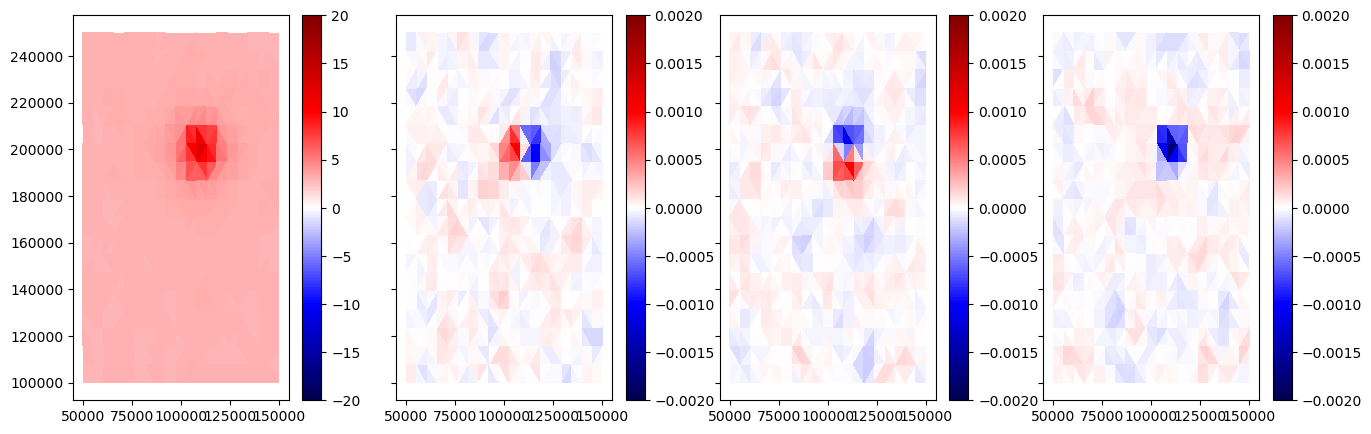

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
tmp = ax.tripcolor(x, y, gravity, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)

for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp)

## Calculate the matrices involved

In [41]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [42]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [43]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [50]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, Wp, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)    
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = B @ Wd_inv @ B.T
    Q_inv = sparse.linalg.inv(Q)
    ATQ = A.T @ Q_inv
    BTQ = B.T @ Q_inv
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    print("Q", Q.todense())
    deltap = np.linalg.solve(
        ATQ @ A + Wp,
        -ATQ @ (f + Br)
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    print("delta_d", deltad)
    return deltap, deltad

In [51]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, maxit=100, tol=1e-5):
    """
    """
    region = vd.get_region(coordinates)
    area = (region[1] - region[0]) * (region[3] - region[2]) / 2
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
    
    parameters = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        -np.mean(coordinates[2]),
        0,
    ])
    #data = np.zeros_like(data_observed)
    data = 0.9 * np.copy(data_observed)
    
    derivative_norm = np.mean([
        np.linalg.norm(xderiv),
        np.linalg.norm(yderiv),
        np.linalg.norm(zderiv),        
    ])   
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field)),
        np.full_like(field, 1 / derivative_norm),
        np.full_like(field, 1 / derivative_norm),
        np.full_like(field, 1 / derivative_norm),
    ])
    wp = np.array([
        1 / area,
        1 / area,
        1 / area,
        1 / np.linalg.norm(field) ** 2,
    ])
    wp = np.where(wp > 1e-15, wp, 1e-15)
    
    print("Data weights:", wd)
    print("Parameter weights:", wp)
    
    Wd_inv = sparse.diags(1 / wd ** 2, format="csc")
    Wp = sparse.diags(wp, format="csc")
    
    euler_misfit = np.linalg.norm(eulers_equation(*coordinates, data, parameters, structural_index))
    misfit = np.linalg.norm((data_observed - data) * 1)
    print("Initial state | Euler misfit: {:.3f} | data misfit: {:.3f}".format(euler_misfit, misfit))
    
    for i in range(maxit):
        deltap, deltad = gauss_newton_step(
            parameters,
            data, 
            coordinates, 
            data_observed, 
            Wd_inv, 
            Wp, 
            structural_index,
        )
        parameters += deltap
        data += deltad
        new_misfit = np.linalg.norm((data_observed - data) * 1)
        misfit_change = np.abs(misfit - new_misfit) / misfit
        misfit = new_misfit
        euler_misfit = np.linalg.norm(
            eulers_equation(*coordinates, data, parameters, structural_index)
        )
        print(" delta p: {} | Euler misfit: {:.8f} | data misfit: {:.3f}".format(deltap, euler_misfit, misfit))
        if misfit_change < tol:
            break
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [52]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=2, 
)
print()
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))
print()

Data weights: [1.47975760e-02 1.47975760e-02 1.47975760e-02 ... 2.71748441e+02
 2.71748441e+02 2.71748441e+02]
Parameter weights: [1.33333333e-10 1.33333333e-10 1.33333333e-10 2.18968255e-04]
Initial state | Euler misfit: 163.763 | data misfit: 6.758
Q [[128413.82151949      0.              0.         ...      0.
       0.              0.        ]
 [     0.         121661.84101038      0.         ...      0.
       0.              0.        ]
 [     0.              0.         115660.08055784 ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ... 115660.08055784
       0.              0.        ]
 [     0.              0.              0.         ...      0.
  121661.84101038      0.        ]
 [     0.              0.              0.         ...      0.
       0.         128413.82151949]]
delta_d [ 2.83189859e-01  1.34969779e+00 -1.19402172e+00 ...  4.11297660e-06
 -2.07933295e-05 -5.68283626e-06]
 delta p: [4.76006938e+03 1.34540708e+04

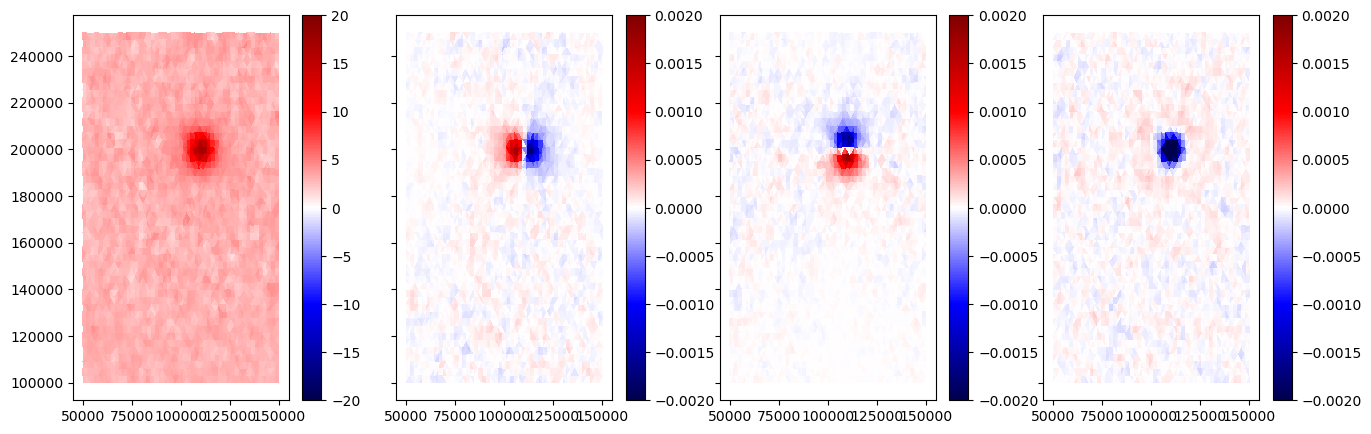

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
tmp = ax.tripcolor(x, y, h, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp)

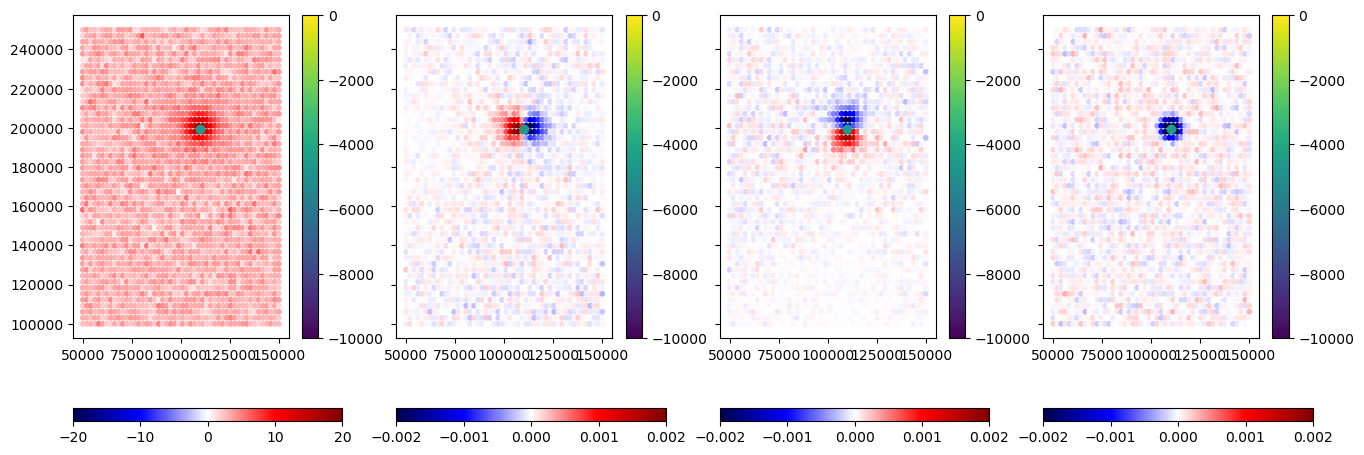

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

In [21]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=3, 
)

Data weights: [5.82265404e-03 5.82265404e-03 5.82265404e-03 ... 1.03819430e+02
 1.03819430e+02 1.03819430e+02]
Parameter weights: [1.33333333e-10 1.33333333e-10 1.33333333e-10 3.39033001e-05]
Initial state | Euler misfit: 579.530 | data misfit: 0.000


/tmp/ipykernel_214768/2413198854.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  misfit_change = np.abs(misfit - new_misfit) / misfit


 delta p: [ 4.86159367e+03  1.12087971e+04 -4.55185376e+03  3.13076892e+00] | Euler misfit: 26.94341219 | data misfit: 55.941
 delta p: [ 2.49838753e+03  6.19698766e+03 -1.58531692e+03 -5.05781848e-03] | Euler misfit: 4.78134625 | data misfit: 49.920
 delta p: [ 1.26035856e+03  3.08075818e+03 -5.29436720e+02 -5.22328875e-03] | Euler misfit: 1.12559960 | data misfit: 46.156
 delta p: [ 6.12164834e+02  1.56468797e+03 -1.61721178e+02 -1.11328739e-03] | Euler misfit: 0.24148715 | data misfit: 44.880
 delta p: [ 2.91873976e+02  7.71624692e+02 -4.92133434e+01 -2.65219135e-04] | Euler misfit: 0.05618216 | data misfit: 44.420
 delta p: [ 1.38286589e+02  3.79383300e+02 -1.39769398e+01 -6.07716470e-05] | Euler misfit: 0.01322431 | data misfit: 44.235
 delta p: [ 6.52671080e+01  1.85992868e+02 -3.46279103e+00 -1.00725634e-05] | Euler misfit: 0.00313450 | data misfit: 44.155
 delta p: [ 3.07300217e+01  9.11126049e+01 -5.31556680e-01  1.01714598e-06] | Euler misfit: 0.00074409 | data misfit: 44.118

In [22]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

109785.7 198566.2 -8394.8 3.1
110000.0 200000.0 -5000.0 3.0


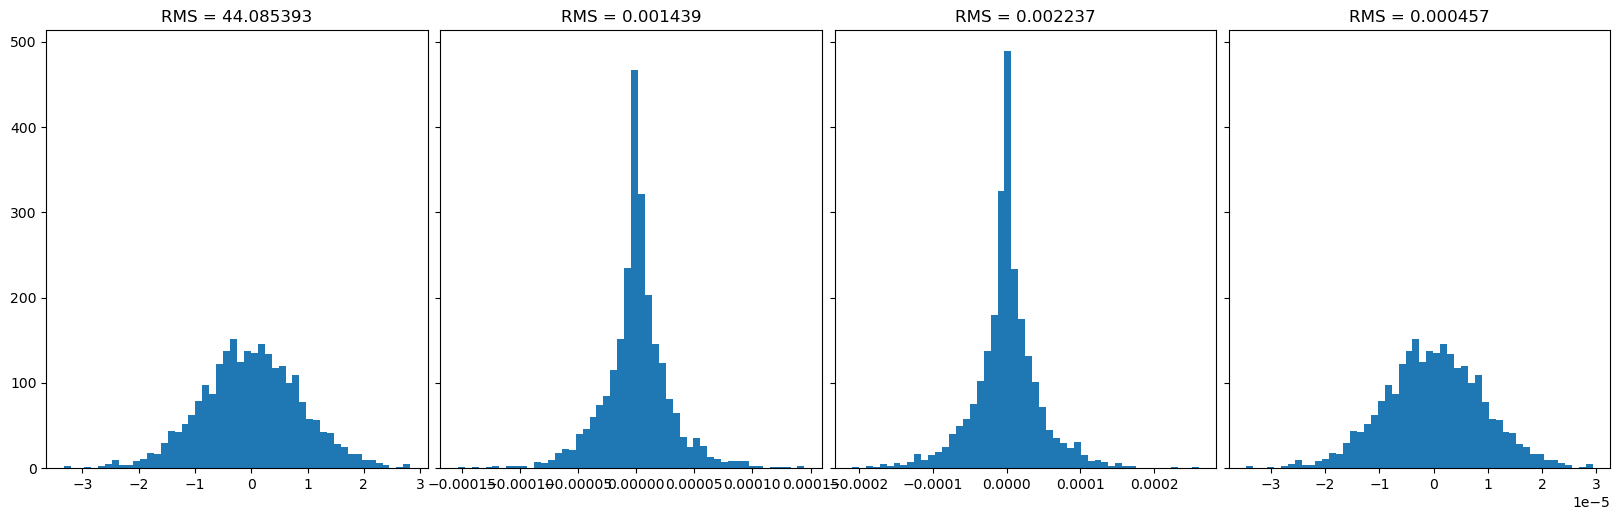

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

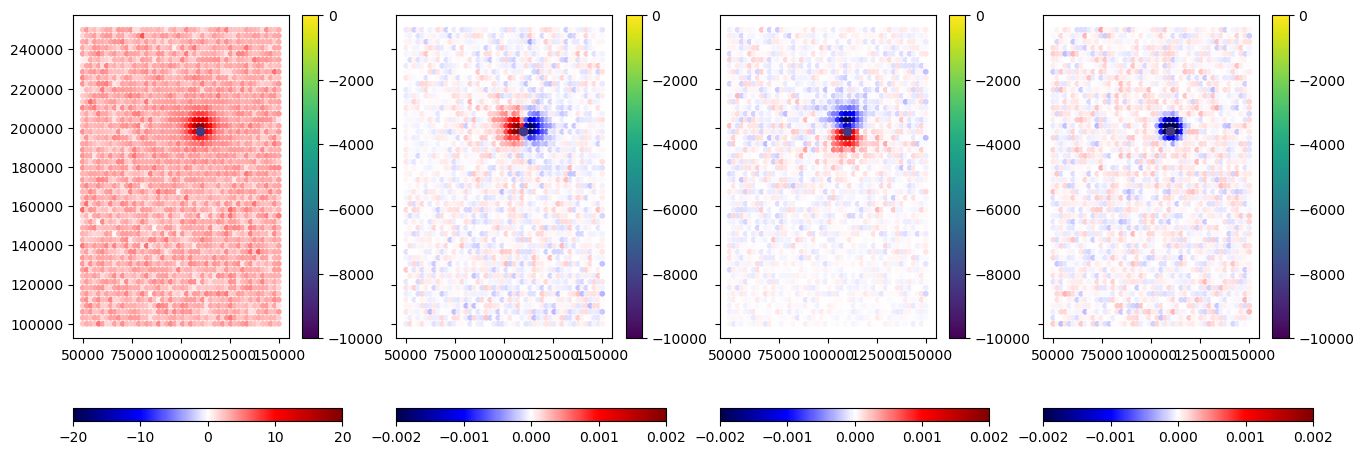

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

In [ ]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=1, 
)

In [ ]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")